# Neural Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mnist_get_images import get_images

%matplotlib inline

The MNIST dataset (Modified National Institute of Standards and Technology dataset) is a large collection of handwritten digits that is commonly used for training and testing image processing systems and machine learning models. Here are some key points about the MNIST dataset:

1. **Content**: It contains 70,000 grayscale images of handwritten digits from 0 to 9. Each image is 28x28 pixels in size.

2. **Training and Testing Split**: The dataset is divided into a training set of 60,000 images and a test set of 10,000 images.

3. **Usage**: It is widely used for benchmarking machine learning algorithms, particularly in the field of image recognition and classification.

4. **Format**: Each image is represented as a 28x28 pixel grid, where each pixel value ranges from 0 (black) to 255 (white).

5. **Labels**: Each image is associated with a label indicating the digit (0-9) that the image represents.

The MNIST dataset is popular because it is relatively simple and small, yet it provides a challenging task for algorithms to achieve high accuracy. It serves as a standard benchmark for evaluating the performance of various machine learning models and techniques.

In [2]:
mnist_path = './mnist_raw/'

In [3]:
X_train_num, y_train_num, X_test_num, y_test_num = get_images(mnist_path)

# Testing data
print(f'Training data dimensions: {X_train_num.shape} \nTesting data dimensions: {X_test_num.shape}')

Training data dimensions: (60000, 28, 28) 
Testing data dimensions: (10000, 28, 28)


## Images to vectors in float32

In this section, the data is prepared and split for training, validation, and testing of a neural network.

1. `X_train` and `y_train`: The first 50,000 examples from the original training data (`X_train_num` and `y_train_num`) are selected, reshaped, and normalized to be used for model training.
2. `x_validation` and `y_validation`: The last 10,000 examples from the original training data are selected to be used as the validation set.
3. `X_test` and `y_test`: The original test data (`X_test_num` and `y_test_num`) are copied and reshaped to be used for the final evaluation of the model.

Additionally, the maximum values of `X_train` and the shapes of the datasets `X_train`, `y_train`, `X_test`, and `y_test` are printed to verify that the data preparation has been done correctly.

In [4]:
X_train = X_train_num[:50_000].reshape(50_000, -1).astype(np.float32)/255
y_train = y_train_num[:50_000].reshape(50_000, 1)

x_validation = X_train_num[50_000:].reshape(10_000, -1).astype(np.float32)/255
y_validation = y_train_num[50_000:].reshape(10_000, 1)

X_test = X_test_num.copy().reshape(10_000, -1).astype(np.float32)/255
y_test = y_test_num.copy().reshape(10_000, 1)

# Testing set
print(f'X_train: {X_train.max()} \n')

# Shape
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')

print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: 1.0 

X_train: (50000, 784)
y_train: (50000, 1)
X_test: (10000, 784)
y_test: (10000, 1)


## Graph image

To visualize the images in the dataset, we can use the `plot_img_number` function defined earlier. Below is an example of how to plot a random image from the test set:

In [5]:
def plot_img_number(image):
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

The image shown corresponds to: [0]


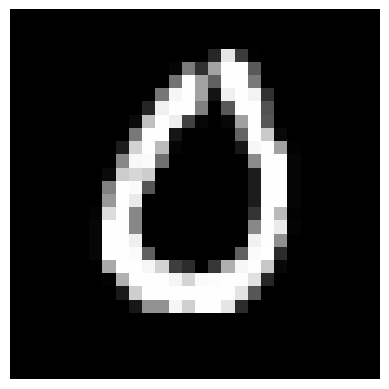

In [6]:
rand_idx = np.random.randint(len(y_test))
print(f'The image shown corresponds to: {y_test[rand_idx]}')
plot_img_number(X_test_num[rand_idx])

### Forward Propagation and Cost Function in Neural Networks

This set of equations describes the flow of a simple neural network model, consisting of an input layer, a hidden layer with ReLU activation function, and an output layer with Softmax activation function for classification. Then, the cross-entropy loss function is used to calculate the error between the predictions and the true values, and finally, the total cost is calculated as the average of the losses across all samples.

1. **Forward Propagation (First Hidden Layer):**

   $$ z^{(1)} = W^{(1)} X + b^{(1)} $$
   
   Where:
   - $ z^{(1)} $ is the linear output of the first layer.
   - $ W^{(1)} $ is the weight matrix of the first layer.
   - $ X $ is the input feature set.
   - $ b^{(1)} $ is the bias vector of the first layer.

2. **Activation (ReLU) in the First Layer:**

   $$ a^{(1)} = \text{ReLU}(z^{(1)}) $$
   
   Where:
   - $ a^{(1)} $ is the output of the ReLU activation function, which applies a non-linear transformation to $ z^{(1)} $.

3. **Forward Propagation (Second Output Layer):**

   $$ z^{(2)} = W^{(2)} a^{(1)} + b^{(2)} $$
   
   Where:
   - $ z^{(2)} $ is the linear output of the second layer.
   - $ W^{(2)} $ is the weight matrix of the second layer.
   - $ a^{(1)} $ is the output of the first layer after activation.
   - $ b^{(2)} $ is the bias vector of the second layer.

4. **Softmax Activation Function (to obtain the probabilities of each class):**

   $$ \hat{y} = \frac{e^{z_k^{(2)}}}{\sum_j e^{z_j^{(2)}}} $$
   
   Where:
   - $ \hat{y} $ represents the predicted probabilities for each class.
   - $ e^{z_k^{(2)}} $ is the exponential of the output $ z_k^{(2)} $ for a class $ k $.
   - $ \sum_j e^{z_j^{(2)}} $ is the sum of exponentials for all classes $ j $, ensuring that the probabilities sum to 1.

5. **Loss Function (Cross-Entropy):**

   $$ \mathcal{L}(\hat{y}^i, y^i) = -y^i \ln(\hat{y}^i) = -\ln(\hat{y}^i) $$
   
   Where:
   - $ \mathcal{L}(\hat{y}^i, y^i) $ is the loss for sample $ i $.
   - $ y^i $ is the true class value (in one-hot encoding).
   - $ \hat{y}^i $ is the predicted probability for the true class.

6. **Average Cost Function for the Entire Dataset:**

   $$ J(w, b) = \frac{1}{\text{num\_samples}} \sum_{i=1}^{\text{num\_samples}} -\ln(\hat{y}^i) $$
   
   Where:
   - $ J(w, b) $ is the total cost of the model, calculated as the average loss across all samples.
   - $ \text{num\_samples} $ is the total number of samples in the dataset.
   - $ -\ln(\hat{y}^i) $ is the loss for sample $ i $.

## Functions for Creating and Training the Neural Network

2 layers 200-10

In [7]:
def create_minibatches(mb_size, x, y, shuffle=True):
    """
    Create minibatches from input data.

    Args:
        mb_size (int): The size of each minibatch.
        x (ndarray): The input data of shape (number of samples, 784).
        y (ndarray): The target data of shape (number of samples, 1).
        shuffle (bool, optional): Whether to shuffle the data before creating minibatches. Defaults to True.

    Returns:
        generator: A generator that yields minibatches of size mb_size from the input data.
    """
    assert x.shape[0] == y.shape[0], "Error in the number of samples"
    total_data = x.shape[0]
    indices = np.arange(total_data)

    if shuffle:
        np.random.shuffle(indices)

    for start_idx in range(0, total_data, mb_size):
        end_idx = min(start_idx + mb_size, total_data)
        batch_indices = indices[start_idx:end_idx]
        yield x[batch_indices], y[batch_indices]

## Init parameters

The function uses He initialization for the weights, which helps maintain the variance of activations across network layers, thus improving convergence during training. 

In [8]:
def init_parameters(input_size, neurons):
    """
    Initializes the parameters for a neural network with one hidden layer.

    Args:
        input_size (int): The number of input elements (e.g., 784 for a 28x28 image).
        neurons (list): A list containing the number of neurons in each layer,
                        e.g., [200, 10] where 200 is the number of neurons in the hidden layer
                        and 10 is the number of neurons in the output layer.

    Returns:
        dict: A dictionary containing the initialized weights and biases:
            - "w1": Weight matrix for the hidden layer, shape (neurons[0], input_size)
            - "b1": Bias vector for the hidden layer, shape (neurons[0], 1)
            - "w2": Weight matrix for the output layer, shape (neurons[1], neurons[0])
            - "b2": Bias vector for the output layer, shape (neurons[1], 1)
    """
    # He initialization for weights
    w1 = np.random.randn(neurons[0], input_size) * np.sqrt(2. / input_size)
    b1 = np.zeros((neurons[0], 1))

    w2 = np.random.randn(neurons[1], neurons[0]) * np.sqrt(2. / neurons[0])
    b2 = np.zeros((neurons[1], 1))

    return {"w1": w1, "b1": b1, "w2": w2, "b2": b2}

In [9]:
parameters = init_parameters(28 * 28, [200, 10])

print(f'Weight matrix for hidden layer (w1) shape: {parameters["w1"].shape}')
print(f'Weight matrix for output layer (w2) shape: {parameters["w2"].shape}')
print(f'Bias vector for output layer (b2) shape: {parameters["b2"].shape}')

Weight matrix for hidden layer (w1) shape: (200, 784)
Weight matrix for output layer (w2) shape: (10, 200)
Bias vector for output layer (b2) shape: (10, 1)


In [10]:
def relu(x):
    return np.maximum(0, x)

In [11]:
def scores(x, parameters, act_function):
    """
    Computes the scores for the neural network with one hidden layer.

    Args:
        x (ndarray): Input data of shape (number of pixels, number of samples).
        parameters (dict): Dictionary containing the weights and biases:
            - "w1": Weight matrix for the hidden layer, shape (neurons[0], input_size)
            - "b1": Bias vector for the hidden layer, shape (neurons[0], 1)
            - "w2": Weight matrix for the output layer, shape (neurons[1], neurons[0])
            - "b2": Bias vector for the output layer, shape (neurons[1], 1)
        act_function (function): Activation function to be applied in the hidden layer.

    Returns:
        tuple: A tuple containing:
            - z2 (ndarray): Output scores of the network, shape (neurons[1], number of samples)
            - z1 (ndarray): Linear output of the hidden layer, shape (neurons[0], number of samples)
            - a1 (ndarray): Activated output of the hidden layer, shape (neurons[0], number of samples)
    """
    z1 = np.dot(parameters["w1"], x) + parameters["b1"]
    a1 = act_function(z1)
    z2 = np.dot(parameters["w2"], a1) + parameters["b2"]

    return z2, z1, a1

In [12]:
output_scores, z1, a1 = scores(X_train[:64].T, parameters, relu)

In [13]:
X_train[:64].T.shape

(784, 64)

In [14]:
def softmax(x):
    """
    Compute the softmax of each element along an axis of X.

    Parameters:
    x (ndarray): Input data, typically a 2D array where each column represents a different data point.

    Returns:
    ndarray: The softmax probabilities of the input data, with the same shape as the input.
    """
    exp_scores = np.exp(x - np.max(x, axis=0, keepdims=True))
    probs = exp_scores / np.sum(exp_scores, axis=0, keepdims=True)
    return probs

In [15]:
def x_entropy(scores, y, batch_size=64):
    """
    Computes the cross-entropy loss and the probabilities for a given set of scores and true labels.

    Args:
        scores (np.ndarray): The predicted scores (logits) for each class, shape (num_classes, batch_size).
        y (np.ndarray): The true labels, shape (batch_size, 1).
        batch_size (int, optional): The number of samples in the batch. Default is 64.

    Returns:
        tuple: A tuple containing:
            - probs (np.ndarray): The probabilities for each class, shape (num_classes, batch_size).
            - cost (float): The cross-entropy loss.
    """
    probs = softmax(scores)
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = -np.mean(np.log(y_hat))
    return probs, cost

In [16]:
y_train.squeeze()[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [17]:
def backward(probs, x, y, z1, a1, parameters, batch_size=64):
    """
    Perform the backward pass for a two-layer neural network.

    Args:
        probs (numpy.ndarray): The probabilities output from the forward pass (shape: [output_size, batch_size]).
        x (numpy.ndarray): The input data (shape: [input_size, batch_size]).
        y (numpy.ndarray): The true labels (shape: [1, batch_size]).
        z1 (numpy.ndarray): The linear output from the first layer (shape: [hidden_size, batch_size]).
        a1 (numpy.ndarray): The activation output from the first layer (shape: [hidden_size, batch_size]).
        parameters (dict): Dictionary containing the network parameters:
            - "w1" (numpy.ndarray): Weights of the first layer (shape: [hidden_size, input_size]).
            - "b1" (numpy.ndarray): Biases of the first layer (shape: [hidden_size, 1]).
            - "w2" (numpy.ndarray): Weights of the second layer (shape: [output_size, hidden_size]).
            - "b2" (numpy.ndarray): Biases of the second layer (shape: [output_size, 1]).
        batch_size (int, optional): The size of the batch. Default is 64.

    Returns:
        dict: Dictionary containing the gradients with respect to the parameters:
            - "w1" (numpy.ndarray): Gradient of the loss with respect to the weights of the first layer.
            - "b1" (numpy.ndarray): Gradient of the loss with respect to the biases of the first layer.
            - "w2" (numpy.ndarray): Gradient of the loss with respect to the weights of the second layer.
            - "b2" (numpy.ndarray): Gradient of the loss with respect to the biases of the second layer.
    """
    grads = {}
    probs[y.squeeze(), np.arange(batch_size)] -= 1  # y-hat - y
    dz2 = probs.copy()

    dW2 = dz2 @ a1.T / batch_size
    db2 = np.sum(dz2, axis=1, keepdims=True) / batch_size
    da1 = parameters["w2"].T @ dz2

    dz1 = da1.copy()
    dz1[z1 <= 0] = 0

    dW1 = dz1 @ x
    db1 = np.sum(dz1, axis=1, keepdims=True)

    assert parameters["w1"].shape == dW1.shape, "W1 shape mismatch"
    assert parameters["w2"].shape == dW2.shape, "W2 shape mismatch"
    assert parameters["b1"].shape == db1.shape, "b1 shape mismatch"
    assert parameters["b2"].shape == db2.shape, "b1 shape mismatch"

    grads = {"w1": dW1, "b1": db1, "w2": dW2, "b2": db2}

    return grads

In [18]:
y_hat, cost = x_entropy(output_scores, y_train[:64])
y_hat.shape

(10, 64)

In [19]:
grads = backward(y_hat, X_train[:64], y_train[:64], z1, a1, parameters)

In [20]:
def accuracy(X_data, y_data, mb_size=64):
    """
    Computes the accuracy of the model predictions.

    Parameters:
    X_data (numpy.ndarray): The input data.
    y_data (numpy.ndarray): The true labels corresponding to the input data.
    mb_size (int, optional): The size of the minibatches. Default is 64.

    Returns:
    float: The accuracy of the model as a fraction of correct predictions over the total number of predictions.
    """
    correct = 0
    total = 0
    for x, y in create_minibatches(mb_size, X_data, y_data):
        points, _, _ = scores(x.T, parameters, relu)
        y_hat = np.argmax(points, axis=0)
        correct += np.sum(y_hat == y.squeeze())
        total += len(y)
    return correct / total

In [21]:
def train(epochs, parameters, mb_size=64, learning_rate=1e-3):
    """
    Trains a neural network using mini-batch gradient descent.

    Args:
        epochs (int): Number of epochs to train the model.
        parameters (dict): Dictionary containing the parameters of the neural network.
        mb_size (int, optional): Size of the mini-batches. Defaults to 64.
        learning_rate (float, optional): Learning rate for the gradient descent. Defaults to 1e-3.

    Returns:
        dict: Updated parameters after training.

    The function performs the following steps:
    1. Iterates over the specified number of epochs.
    2. For each epoch, creates mini-batches from the training data.
    3. Computes the scores, cost, and gradients for each mini-batch.
    4. Updates the parameters using the computed gradients.
    5. Prints the cost and validation accuracy for each epoch.
    """
    for epoch in range(epochs):
        for x, y in create_minibatches(mb_size, X_train, y_train):
            points, z1, a1 = scores(x.T, parameters=parameters, act_function=relu)
            y_hat, cost = x_entropy(points, y, batch_size=len(x))
            grads = backward(y_hat, x, y, z1, a1, parameters, batch_size=len(x))

            # Update parameters
            for param in parameters:
                parameters[param] -= learning_rate * grads[param]

        # Print cost and accuracy for each epoch
        validation_accuracy = accuracy(x_validation, y_validation, mb_size)
        print(f"Epoch {epoch + 1}/{epochs} - Cost: {cost:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

    return parameters

In [22]:
mb_size = 512
learning_rate = 1e-2
epochs = 20
parameters = train(epochs, parameters, mb_size, learning_rate)

Epoch 1/20 - Cost: 0.3455, Validation Accuracy: 0.9279
Epoch 2/20 - Cost: 0.2595, Validation Accuracy: 0.9394
Epoch 3/20 - Cost: 0.1929, Validation Accuracy: 0.9505
Epoch 4/20 - Cost: 0.1581, Validation Accuracy: 0.9554
Epoch 5/20 - Cost: 0.1622, Validation Accuracy: 0.9593
Epoch 6/20 - Cost: 0.1372, Validation Accuracy: 0.9616
Epoch 7/20 - Cost: 0.1179, Validation Accuracy: 0.9630
Epoch 8/20 - Cost: 0.0978, Validation Accuracy: 0.9640
Epoch 9/20 - Cost: 0.0993, Validation Accuracy: 0.9658
Epoch 10/20 - Cost: 0.1692, Validation Accuracy: 0.9654
Epoch 11/20 - Cost: 0.0853, Validation Accuracy: 0.9666
Epoch 12/20 - Cost: 0.1074, Validation Accuracy: 0.9663
Epoch 13/20 - Cost: 0.0638, Validation Accuracy: 0.9689
Epoch 14/20 - Cost: 0.1032, Validation Accuracy: 0.9689
Epoch 15/20 - Cost: 0.0837, Validation Accuracy: 0.9701
Epoch 16/20 - Cost: 0.1104, Validation Accuracy: 0.9702
Epoch 17/20 - Cost: 0.0607, Validation Accuracy: 0.9698
Epoch 18/20 - Cost: 0.0731, Validation Accuracy: 0.9701
E

In [23]:
print(f'Accuracy on train set: {accuracy(X_train, y_train, mb_size):.2%}')
print(f'Accuracy on test set: {accuracy(X_test, y_test, mb_size):.2%}')

Accuracy on train set: 98.11%
Accuracy on test set: 96.82%


In [24]:
def predict(x):
    """
    Predicts the class of each input sample.

    Args:
        x (ndarray): Input data of shape (number of pixels, number of samples).
    Returns:
        ndarray: Predicted class for each input sample.
    """
    points, _, _ = scores(x.T, parameters, relu)
    return np.argmax(points, axis=0)